<a href="https://colab.research.google.com/github/pa7003/RL_DQN_REINFORCE_A2C./blob/main/RL_Assignment_DQN_REINFORCE_A2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DQN implementation using gymnasium**

# Step 1: Install Necessary Libraries and Import PyTorch/Gym

In [ ]:
!pip install gymnasium[classic_control]
!pip install pygame

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import math
from collections import deque # For replay buffer
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Step 2: Set up the Environment and Hyperparameters

In [ ]:
# Environment
ENV_NAME = 'CartPole-v1'
# Initialize gymnasium environment
env = gym.make(ENV_NAME)

# Get state and action space dimensions
# For gymnasium, observation_space and action_space are typically from gym.spaces
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

print(f"Environment: {ENV_NAME}")
print(f"State Dimension: {state_dim}")
print(f"Action Dimension: {action_dim}")

# DQN Hyperparameters
BUFFER_SIZE = 100000   # Replay buffer size
BATCH_SIZE = 64        # Minibatch size for training
GAMMA = 0.99           # Discount factor
LR = 1e-4              # Learning rate for the Q-network
EPS_START = 1.0        # Initial exploration rate
EPS_END = 0.01         # Minimum exploration rate
EPS_DECAY = 1000       # Rate of exponential decay for epsilon
TARGET_UPDATE = 10     # How often to update the target network (in episodes)
NUM_EPISODES = 1500    # Total number of episodes to train

Environment: CartPole-v1
State Dimension: 4
Action Dimension: 2


# Step 3: Define the Q-Network and Replay Buffer

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Initialize policy and target networks
policy_net = QNetwork(state_dim, action_dim).to(device)
target_net = QNetwork(state_dim, action_dim).to(device)
target_net.load_state_dict(policy_net.state_dict()) # Copy weights
target_net.eval() # Set target network to evaluation mode (no gradients)

print("Q-Network initialized.")

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        # Convert to appropriate types if necessary (e.g., NumPy to list/tuple)
        # Gymnasium states are typically numpy arrays, convert to list for consistency in deque
        state = np.asarray(state).tolist()
        next_state = np.asarray(next_state).tolist()
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        # Transpose batch (stack S, A, R, S', D to separate lists)
        states, actions, rewards, next_states, dones = zip(*transitions)
        return (torch.tensor(states, dtype=torch.float32).to(device),
                torch.tensor(actions, dtype=torch.long).to(device),
                torch.tensor(rewards, dtype=torch.float32).to(device),
                torch.tensor(next_states, dtype=torch.float32).to(device),
                torch.tensor(dones, dtype=torch.bool).to(device))

    def __len__(self):
        return len(self.buffer)

replay_buffer = ReplayBuffer(BUFFER_SIZE)
print("Replay Buffer initialized.")

Q-Network initialized.
Replay Buffer initialized.


# Step 4: Implement the epsilon-Greedy Action Selection Policy

In [ ]:
def select_action(state, epsilon):
    # Ensure state is a tensor and on the correct device
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

    if random.random() > epsilon:
        with torch.no_grad(): # Don't track gradients for action selection
            q_values = policy_net(state)
        return q_values.argmax(dim=1).item() # Select action with max Q-value
    else:
        return env.action_space.sample() # Choose a random action

print("Epsilon-Greedy policy function defined.")

Epsilon-Greedy policy function defined.


# Step 5: Define the Optimizer and Learning Function

In [ ]:
optimizer = optim.Adam(policy_net.parameters(), lr=LR)
print(f"Optimizer (Adam) initialized with learning rate: {LR}")

def optimize_model():
    if len(replay_buffer) < BATCH_SIZE:
        return # Not enough samples to train

    states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)

    # Compute Q(s_t, a) - the Q-values for the actions taken
    current_q_values = policy_net(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

    # Compute V(s_{t+1}) for all next states.
    with torch.no_grad(): # No gradients needed for target calculation
        next_state_q_values = target_net(next_states).max(1)[0]
        next_state_q_values[dones] = 0.0

    # Compute the expected Q values (Bellman Equation)
    expected_q_values = rewards + GAMMA * next_state_q_values

    # Compute Huber loss (more robust to outliers than MSE)
    loss = F.smooth_l1_loss(current_q_values, expected_q_values)

    # Optimize the model
    optimizer.zero_grad() # Clear previous gradients
    loss.backward()       # Compute gradients
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1) # Gradient clipping
    optimizer.step()      # Update weights

    return loss.item() # Return the loss value

Optimizer (Adam) initialized with learning rate: 0.0001


# Step 6: The Main Training Loop (Adapted for gymnasium)

In [ ]:
episode_rewards = []
moving_average_rewards = []
episode_losses = [] # To store training losses

print("Starting DQN training...")
for episode in range(1, NUM_EPISODES + 1):
    # Gymnasium's reset returns (observation, info)
    state, info = env.reset()
    total_reward = 0
    # In gymnasium, 'done' is split into 'terminated' and 'truncated'
    terminated = False
    truncated = False
    step = 0

    # Calculate epsilon for the current episode
    epsilon = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * episode / EPS_DECAY)

    while not terminated and not truncated:
        action = select_action(state, epsilon)
        # Gymnasium's step returns (observation, reward, terminated, truncated, info)
        next_state, reward, terminated, truncated, info = env.step(action)

        # Store the transition in replay buffer
        # 'done' for replay buffer is true if either terminated or truncated
        replay_buffer.push(state, action, reward, next_state, terminated or truncated)

        state = next_state
        total_reward += reward
        step += 1

        # Perform one optimization step if enough samples are in the buffer
        if len(replay_buffer) > BATCH_SIZE:
            loss = optimize_model()
            if loss is not None:
                episode_losses.append(loss)

    episode_rewards.append(total_reward)

    # Update the target network periodically
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Calculate moving average
    if len(episode_rewards) >= 50:
        ma_reward = np.mean(episode_rewards[-50:])
    else:
        ma_reward = np.mean(episode_rewards)
    moving_average_rewards.append(ma_reward)

    print(f"Episode {episode}/{NUM_EPISODES}, Reward: {total_reward:.2f}, Avg Reward (last 50): {ma_reward:.2f}, Epsilon: {epsilon:.4f}", end='\r')
    if episode % 100 == 0: # Print full line every 100 episodes
        print(f"Episode {episode}/{NUM_EPISODES}, Reward: {total_reward:.2f}, Avg Reward (last 50): {ma_reward:.2f}, Epsilon: {epsilon:.4f}")

env.close()
print("\nDQN Training finished.")

# Save the trained DQN model
torch.save(policy_net.state_dict(), 'dqn_model.pt')
print("DQN model saved as dqn_model.pt")


Starting DQN training...
Episode 100/1500, Reward: 15.00, Avg Reward (last 50): 21.76, Epsilon: 0.9058
Episode 200/1500, Reward: 16.00, Avg Reward (last 50): 28.54, Epsilon: 0.8205
Episode 300/1500, Reward: 26.00, Avg Reward (last 50): 34.94, Epsilon: 0.7434
Episode 400/1500, Reward: 37.00, Avg Reward (last 50): 46.60, Epsilon: 0.6736
Episode 500/1500, Reward: 63.00, Avg Reward (last 50): 53.28, Epsilon: 0.6105
Episode 600/1500, Reward: 76.00, Avg Reward (last 50): 45.24, Epsilon: 0.5533
Episode 700/1500, Reward: 10.00, Avg Reward (last 50): 33.54, Epsilon: 0.5016
Episode 800/1500, Reward: 96.00, Avg Reward (last 50): 43.44, Epsilon: 0.4548
Episode 900/1500, Reward: 50.00, Avg Reward (last 50): 37.52, Epsilon: 0.4125
Episode 1000/1500, Reward: 33.00, Avg Reward (last 50): 34.00, Epsilon: 0.3742
Episode 1100/1500, Reward: 48.00, Avg Reward (last 50): 43.22, Epsilon: 0.3395
Episode 1200/1500, Reward: 80.00, Avg Reward (last 50): 46.80, Epsilon: 0.3082
Episode 1300/1500, Reward: 82.00, Av

# Step 7: Plotting Performance

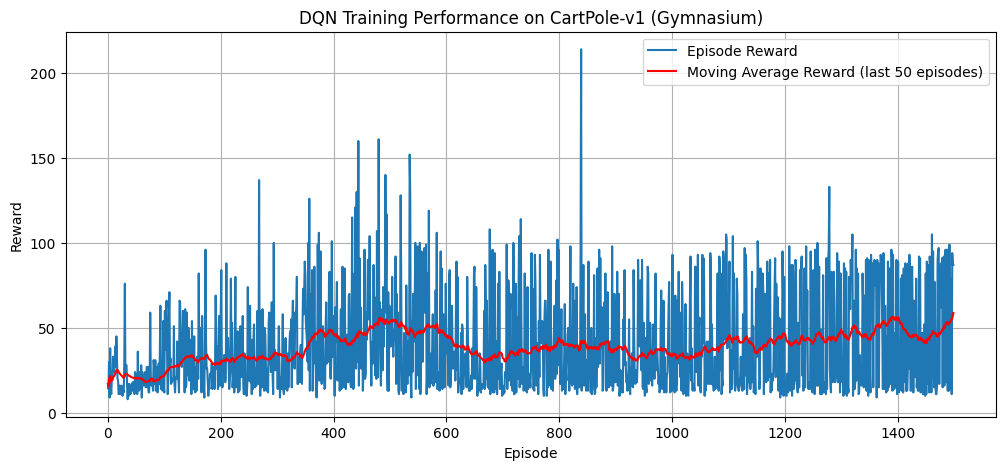

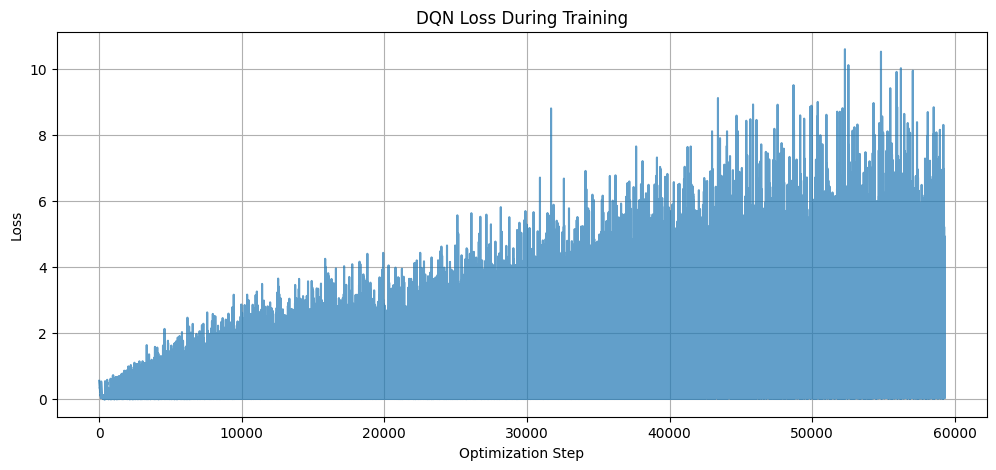

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(episode_rewards, label='Episode Reward')
plt.plot(moving_average_rewards, label=f'Moving Average Reward (last 50 episodes)', color='red')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN Training Performance on CartPole-v1 (Gymnasium)')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Plotting loss
if episode_losses:
    plt.figure(figsize=(12, 5))
    plt.plot(episode_losses, label='DQN Loss', alpha=0.7)
    plt.xlabel('Optimization Step')
    plt.ylabel('Loss')
    plt.title('DQN Loss During Training')
    plt.grid(True)
    plt.show()

#  DQN: Inference Demonstration

In [ ]:
print("\n--- Running DQN Inference ---")

# Load the saved DQN model
loaded_dqn_policy_net = QNetwork(state_dim, action_dim).to(device)
loaded_dqn_policy_net.load_state_dict(torch.load('dqn_model.pt'))
loaded_dqn_policy_net.eval() # Set to evaluation mode

# Create a new environment for rendering
render_env_dqn = gym.make(ENV_NAME, render_mode='human') # Use 'human' for visual rendering

num_inference_episodes = 5
for i_episode in range(num_inference_episodes):
    state, info = render_env_dqn.reset()
    total_reward = 0
    terminated = False
    truncated = False

    print(f"DQN Inference Episode {i_episode + 1}:")
    while not terminated and not truncated:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            action = loaded_dqn_policy_net(state_tensor).argmax(dim=1).item()

        state, reward, terminated, truncated, info = render_env_dqn.step(action)
        total_reward += reward

    print(f"  Total Reward: {total_reward:.2f}")

render_env_dqn.close()
print("DQN Inference finished.")


# **Policy Gradient (REINFORCE) algorithm**

# Step 1: REINFORCE - Define Policy Network

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim) # Output logits for actions

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        # No softmax here, as Categorical distribution will handle it internally for log_prob
        return self.fc3(x)

# Initialize Policy Network for REINFORCE
policy_net_reinforce = PolicyNetwork(state_dim, action_dim).to(device)
optimizer_reinforce = optim.Adam(policy_net_reinforce.parameters(), lr=LR) # Using same LR for now

print("REINFORCE Policy Network initialized.")

# Step 2: REINFORCE - Training Loop

In [ ]:
reinforce_episode_rewards = []
reinforce_moving_average_rewards = []

# REINFORCE specific hyperparameters (can be same as DQN for common ones)
REINFORCE_NUM_EPISODES = NUM_EPISODES # Use the same number of episodes for consistency
REINFORCE_GAMMA = GAMMA

print("\nStarting REINFORCE training...")
for episode in range(1, REINFORCE_NUM_EPISODES + 1):
    state, info = env.reset()
    log_probs = []
    rewards = []
    total_reward = 0
    terminated = False
    truncated = False

    while not terminated and not truncated:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        action_logits = policy_net_reinforce(state_tensor)

        # Create a categorical distribution from logits
        dist = torch.distributions.Categorical(logits=action_logits)
        action = dist.sample() # Sample an action from the distribution
        log_prob = dist.log_prob(action) # Get the log-probability of the sampled action

        next_state, reward, terminated, truncated, info = env.step(action.item()) # .item() to convert tensor to Python int

        log_probs.append(log_prob)
        rewards.append(reward)
        state = next_state
        total_reward += reward

    reinforce_episode_rewards.append(total_reward)

    # Calculate Monte Carlo returns (G_t)
    # G_t = R_t + gamma * R_{t+1} + gamma^2 * R_{t+2} + ...
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + REINFORCE_GAMMA * G
        returns.insert(0, G) # Insert at the beginning to maintain original order

    returns = torch.tensor(returns, dtype=torch.float32).to(device)
    # Optional: Baseline for variance reduction (e.g., subtracting mean of returns)
    # returns = (returns - returns.mean()) / (returns.std() + 1e-9)

    # Compute loss (negative of objective function to maximize)
    # Sum over steps, weighted by returns. log_probs are already tensors of shape (1,)
    # so we need to concatenate them and then sum
    log_probs_tensor = torch.cat(log_probs).to(device)
    loss = -torch.sum(log_probs_tensor * returns)

    # Optimize the model
    optimizer_reinforce.zero_grad()
    loss.backward()
    optimizer_reinforce.step()

    # Calculate moving average
    if len(reinforce_episode_rewards) >= 50:
        ma_reward = np.mean(reinforce_episode_rewards[-50:])
    else:
        ma_reward = np.mean(reinforce_episode_rewards)
    reinforce_moving_average_rewards.append(ma_reward)

    print(f"REINFORCE Episode {episode}/{REINFORCE_NUM_EPISODES}, Reward: {total_reward:.2f}, Avg Reward (last 50): {ma_reward:.2f}", end='\r')
    if episode % 100 == 0:
        print(f"REINFORCE Episode {episode}/{REINFORCE_NUM_EPISODES}, Reward: {total_reward:.2f}, Avg Reward (last 50): {ma_reward:.2f}")

print("\nREINFORCE Training finished.")

# Save the trained REINFORCE model
torch.save(policy_net_reinforce.state_dict(), 'reinforce_model.pt')
print("REINFORCE model saved as reinforce_model.pt")



Starting REINFORCE training...
REINFORCE Episode 100/1500, Reward: 14.00, Avg Reward (last 50): 26.42
REINFORCE Episode 200/1500, Reward: 18.00, Avg Reward (last 50): 30.56
REINFORCE Episode 300/1500, Reward: 67.00, Avg Reward (last 50): 39.80
REINFORCE Episode 400/1500, Reward: 31.00, Avg Reward (last 50): 42.00
REINFORCE Episode 500/1500, Reward: 13.00, Avg Reward (last 50): 55.20
REINFORCE Episode 600/1500, Reward: 66.00, Avg Reward (last 50): 93.60
REINFORCE Episode 700/1500, Reward: 190.00, Avg Reward (last 50): 128.64
REINFORCE Episode 800/1500, Reward: 240.00, Avg Reward (last 50): 160.42
REINFORCE Episode 900/1500, Reward: 141.00, Avg Reward (last 50): 205.84
REINFORCE Episode 1000/1500, Reward: 364.00, Avg Reward (last 50): 218.88
REINFORCE Episode 1100/1500, Reward: 227.00, Avg Reward (last 50): 239.10
REINFORCE Episode 1200/1500, Reward: 500.00, Avg Reward (last 50): 269.34
REINFORCE Episode 1300/1500, Reward: 165.00, Avg Reward (last 50): 293.42
REINFORCE Episode 1400/1500

# Step 3: REINFORCE - Plotting Performance

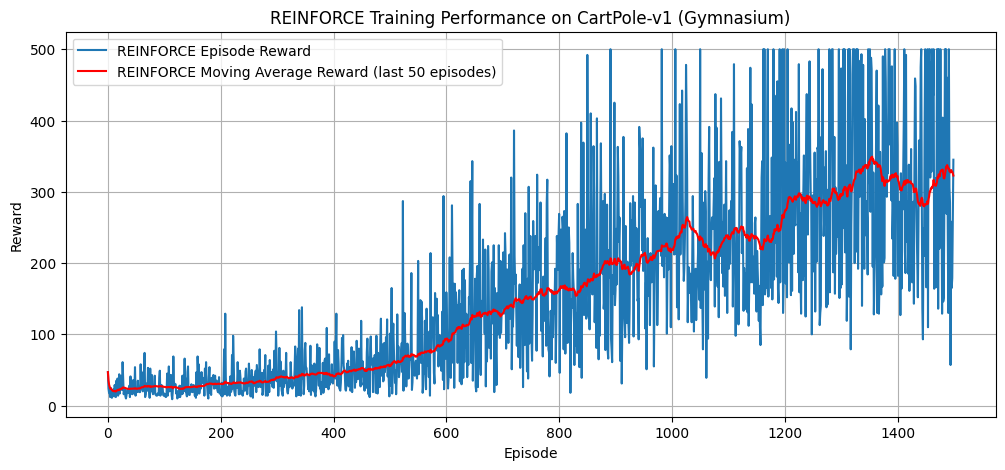

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(reinforce_episode_rewards, label='REINFORCE Episode Reward')
plt.plot(reinforce_moving_average_rewards, label=f'REINFORCE Moving Average Reward (last 50 episodes)', color='red')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('REINFORCE Training Performance on CartPole-v1 (Gymnasium)')
plt.legend()
plt.grid(True)
plt.show()

# REINFORCE: Inference Demonstration

In [ ]:
print("\n--- Running REINFORCE Inference ---")

# Load the saved REINFORCE model
loaded_reinforce_policy_net = PolicyNetwork(state_dim, action_dim).to(device)
loaded_reinforce_policy_net.load_state_dict(torch.load('reinforce_model.pt'))
loaded_reinforce_policy_net.eval() # Set to evaluation mode

# Create a new environment for rendering
render_env_reinforce = gym.make(ENV_NAME, render_mode='human') # Use 'human' for visual rendering

num_inference_episodes = 5
for i_episode in range(num_inference_episodes):
    state, info = render_env_reinforce.reset()
    total_reward = 0
    terminated = False
    truncated = False

    print(f"REINFORCE Inference Episode {i_episode + 1}:")
    while not terminated and not truncated:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            action_logits = loaded_reinforce_policy_net(state_tensor)
            # For inference, typically choose the greedy action (highest probability)
            action = torch.distributions.Categorical(logits=action_logits).sample().item() # Or .argmax(dim=1).item()

        state, reward, terminated, truncated, info = render_env_reinforce.step(action)
        total_reward += reward

    print(f"  Total Reward: {total_reward:.2f}")

render_env_reinforce.close()
print("REINFORCE Inference finished.")


# **Actor-Critic (A2C) algorithm.**

# Step 1: Actor-Critic - Define Actor and Critic Networks

In [ ]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim) # Output logits for actions

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1) # Output a single state-value estimate V(s)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Initialize Actor and Critic Networks
actor_net = Actor(state_dim, action_dim).to(device)
critic_net = Critic(state_dim).to(device)

# A single optimizer for both networks (common for A2C if updating together)
# Or separate optimizers if preferred
optimizer_actor_critic = optim.Adam(list(actor_net.parameters()) + list(critic_net.parameters()), lr=LR)

print("Actor and Critic Networks initialized.")

# Step 2: Actor-Critic - Training Loop

In [ ]:
ac_episode_rewards = []
ac_moving_average_rewards = []

# Actor-Critic specific hyperparameters (can be same as DQN/REINFORCE for common ones)
AC_NUM_EPISODES = NUM_EPISODES
AC_GAMMA = GAMMA
# Coefficient for value loss (to balance actor and critic updates)
VALUE_LOSS_COEF = 0.5
# Coefficient for entropy loss (to encourage exploration)
ENTROPY_COEF = 0.01

print("\nStarting Actor-Critic training...")
for episode in range(1, AC_NUM_EPISODES + 1):
    state, info = env.reset()
    log_probs = []
    values = []
    rewards = []
    total_reward = 0
    terminated = False
    truncated = False

    while not terminated and not truncated:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

        # Get action probabilities from Actor
        action_logits = actor_net(state_tensor)
        dist = torch.distributions.Categorical(logits=action_logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)

        # Get state value estimate from Critic
        value = critic_net(state_tensor)

        next_state, reward, terminated, truncated, info = env.step(action.item())

        log_probs.append(log_prob)
        values.append(value) # Store value as a tensor
        rewards.append(reward)
        state = next_state
        total_reward += reward

    ac_episode_rewards.append(total_reward)

    # Calculate discounted returns (targets for the Critic)
    returns = []
    G = 0
    # For Actor-Critic, the G is often computed with the last value estimate
    # or just for current episode's rewards for simplicity (Monte Carlo approach for returns)
    # Here, we'll use actual episode returns, similar to REINFORCE, for a simple A2C.
    # For more advanced A2C, TD(0) or GAE for advantages is used.
    for r in reversed(rewards):
        G = r + AC_GAMMA * G
        returns.insert(0, G)
    returns = torch.tensor(returns, dtype=torch.float32).to(device)

    # Convert values list of single-element tensors to a single tensor
    values_tensor = torch.cat(values).squeeze(-1).to(device) # Remove last dim if it's 1

    # Calculate Advantages (TD Error in basic A2C often serves as advantage)
    # Advantage = Return - Value(state)
    advantages = returns - values_tensor.detach() # Detach to prevent gradients flowing to critic from actor's loss

    # Calculate Actor Loss
    actor_loss = -torch.sum(torch.cat(log_probs) * advantages)

    # Calculate Critic Loss (MSE between predicted values and actual returns)
    critic_loss = F.mse_loss(values_tensor, returns)

    # Calculate Entropy Loss (optional, to encourage exploration)
    entropy_loss = -torch.sum(dist.entropy()) # Sum of entropies for actions in the episode

    # Total Loss
    total_loss = actor_loss + VALUE_LOSS_COEF * critic_loss - ENTROPY_COEF * entropy_loss

    # Optimize both networks
    optimizer_actor_critic.zero_grad()
    total_loss.backward()
    # Optional: Gradient clipping
    for param in actor_net.parameters():
        param.grad.data.clamp_(-1, 1)
    for param in critic_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer_actor_critic.step()

    # Calculate moving average
    if len(ac_episode_rewards) >= 50:
        ma_reward = np.mean(ac_episode_rewards[-50:])
    else:
        ma_reward = np.mean(ac_episode_rewards)
    ac_moving_average_rewards.append(ma_reward)

    print(f"AC Episode {episode}/{AC_NUM_EPISODES}, Reward: {total_reward:.2f}, Avg Reward (last 50): {ma_reward:.2f}", end='\r')
    if episode % 100 == 0:
        print(f"AC Episode {episode}/{AC_NUM_EPISODES}, Reward: {total_reward:.2f}, Avg Reward (last 50): {ma_reward:.2f}")

print("\nActor-Critic Training finished.")

# Save the trained Actor-Critic models
torch.save({
    'actor_state_dict': actor_net.state_dict(),
    'critic_state_dict': critic_net.state_dict()
}, 'actor_critic_model.pt')
print("Actor-Critic model saved as actor_critic_model.pt")


# Step 3: Actor-Critic - Plotting Performance

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(ac_episode_rewards, label='Actor-Critic Episode Reward')
plt.plot(ac_moving_average_rewards, label=f'Actor-Critic Moving Average Reward (last 50 episodes)', color='red')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Actor-Critic Training Performance on CartPole-v1 (Gymnasium)')
plt.legend()
plt.grid(True)
plt.show()

# Actor-Critic: Inference Demonstration

In [ ]:
print("\n--- Running Actor-Critic Inference ---")

# Load the saved Actor-Critic models
loaded_ac_models = torch.load('actor_critic_model.pt')
loaded_ac_actor_net = Actor(state_dim, action_dim).to(device)
loaded_ac_actor_net.load_state_dict(loaded_ac_models['actor_state_dict'])
loaded_ac_actor_net.eval() # Set to evaluation mode

# Critic is not strictly needed for inference (action selection)
# loaded_ac_critic_net = Critic(state_dim).to(device)
# loaded_ac_critic_net.load_state_dict(loaded_ac_models['critic_state_dict'])
# loaded_ac_critic_net.eval()

# Create a new environment for rendering
render_env_ac = gym.make(ENV_NAME, render_mode='human') # Use 'human' for visual rendering

num_inference_episodes = 5
for i_episode in range(num_inference_episodes):
    state, info = render_env_ac.reset()
    total_reward = 0
    terminated = False
    truncated = False

    print(f"Actor-Critic Inference Episode {i_episode + 1}:")
    while not terminated and not truncated:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            action_logits = loaded_ac_actor_net(state_tensor)
            # For inference, typically choose the greedy action (highest probability)
            action = torch.distributions.Categorical(logits=action_logits).sample().item() # Or .argmax(dim=1).item()

        state, reward, terminated, truncated, info = render_env_ac.step(action)
        total_reward += reward

    print(f"  Total Reward: {total_reward:.2f}")

render_env_ac.close()
print("Actor-Critic Inference finished.")


# Consolidated Plots

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(moving_average_rewards, label='DQN Moving Average Reward (last 50 episodes)', alpha=0.8)
plt.plot(reinforce_moving_average_rewards, label='REINFORCE Moving Average Reward (last 50 episodes)', alpha=0.8)
plt.plot(ac_moving_average_rewards, label='Actor-Critic Moving Average Reward (last 50 episodes)', alpha=0.8)

plt.xlabel('Episode')
plt.ylabel('Moving Average Reward')
plt.title('Comparison of RL Algorithms on CartPole-v1 (Moving Average Reward)')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation Metrics Calculation

In [ ]:
print("\n--- Evaluation Metrics ---")

# --- Final Average Reward over the last 100 episodes ---
print("\nFinal Average Reward (last 100 episodes):")

dqn_final_avg = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
print(f"DQN: {dqn_final_avg:.2f}")

reinforce_final_avg = np.mean(reinforce_episode_rewards[-100:]) if len(reinforce_episode_rewards) >= 100 else np.mean(reinforce_episode_rewards)
print(f"REINFORCE: {reinforce_final_avg:.2f}")

ac_final_avg = np.mean(ac_episode_rewards[-100:]) if len(ac_episode_rewards) >= 100 else np.mean(ac_episode_rewards)
print(f"Actor-Critic: {ac_final_avg:.2f}")

# --- Estimate Number of Episodes to Converge ---
# For CartPole-v1, "solving" means reaching an average reward of 195 over 100 consecutive episodes.
# We'll define a simple convergence threshold based on this or a high stable reward.
CONVERGENCE_THRESHOLD = 195.0 # For CartPole-v1

def get_convergence_episode(rewards_list, threshold=CONVERGENCE_THRESHOLD, window=100):
    for i in range(len(rewards_list) - window + 1):
        if np.mean(rewards_list[i:i+window]) >= threshold:
            return i + window # Return the episode number when the average was first met
    return "Not converged"

print("\nNumber of Episodes to Converge (Avg reward >= 195.0 over 100 episodes):")
dqn_converged_at = get_convergence_episode(episode_rewards)
print(f"DQN: {dqn_converged_at}")

reinforce_converged_at = get_convergence_episode(reinforce_episode_rewards)
print(f"REINFORCE: {reinforce_converged_at}")

ac_converged_at = get_convergence_episode(ac_episode_rewards)
print(f"Actor-Critic: {ac_converged_at}")

# Hyperparameter Table

| Hyperparameter | DQN | REINFORCE | Actor-Critic |
| :--- | :--- | :--- | :--- |
| `BUFFER_SIZE` | 100000 | N/A | N/A |
| `BATCH_SIZE` | 64 | N/A | N/A |
| `GAMMA` | 0.99 | 0.99 | 0.99 |
| `LR` | 1e-4 | 1e-4 | 1e-4 |
| `EPS_START` | 1.0 | N/A | N/A |
| `EPS_END` | 0.01 | N/A | N/A |
| `EPS_DECAY` | 1000 | N/A | N/A |
| `TARGET_UPDATE` | 10 | N/A | N/A |
| `NUM_EPISODES` | 1500 | 1500 | 1500 |
| `VALUE_LOSS_COEF`| N/A | N/A | 0.5 |
| `ENTROPY_COEF`| N/A | N/A | 0.01 |